In [33]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.2 MB/s eta 0:00:00


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import tensorflow as tf
from kerastuner import RandomSearch

/tmp/ipython-input-2843830037.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


## `Read the Dataset`

In [2]:
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.columns = df.columns.str.lower().str.strip().str.replace(' ','-')
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Check Nans
df.isna().sum().sort_values(ascending=False)

,0
cabin,687
age,177
embarked,2
passengerid,0
name,0
pclass,0
survived,0
sex,0
parch,0
sibsp,0


## `Visualizing`



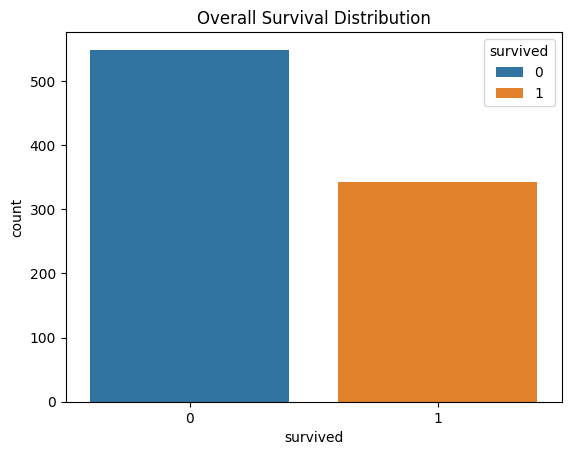

In [7]:
sns.countplot(data=df, x='survived',hue='survived')
plt.title("Overall Survival Distribution")
plt.show()

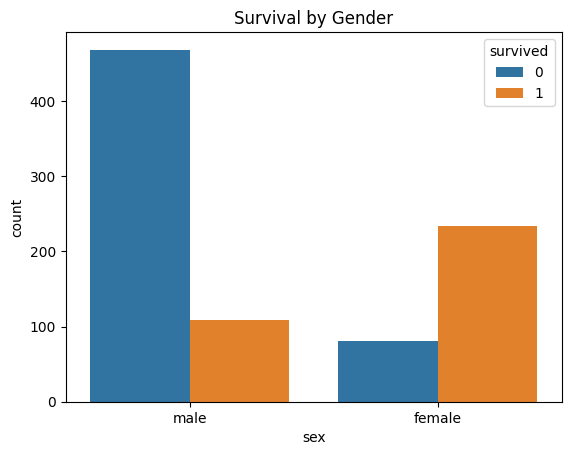

In [8]:
sns.countplot(data=df, x='sex', hue='survived')
plt.title("Survival by Gender")
plt.show()

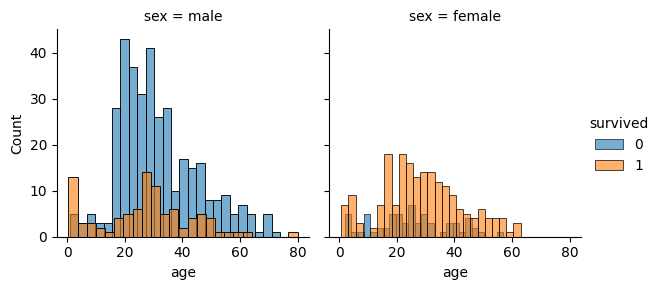

In [9]:
g = sns.FacetGrid(df, col='sex', hue='survived')
g.map(sns.histplot, 'age', bins=25, alpha=0.6)
g.add_legend()
plt.show()

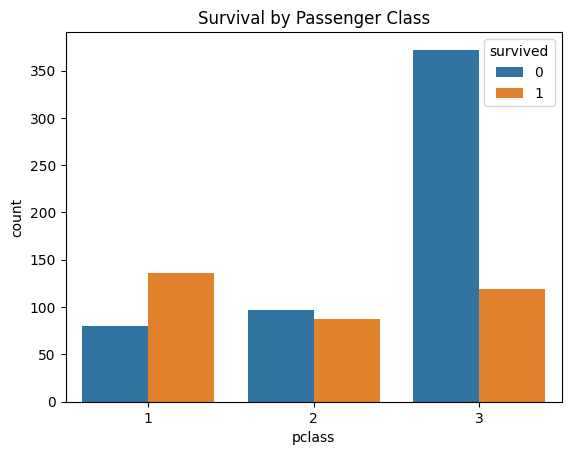

In [10]:
sns.countplot(data=df, x='pclass', hue='survived')
plt.title("Survival by Passenger Class")
plt.show()


The data strongly supports the idea that being female and traveling in a higher class (especially 1st class) greatly increased the likelihood of survival on the Titanic.
Meanwhile, male passengers and those in 3rd class faced the highest fatality rates.

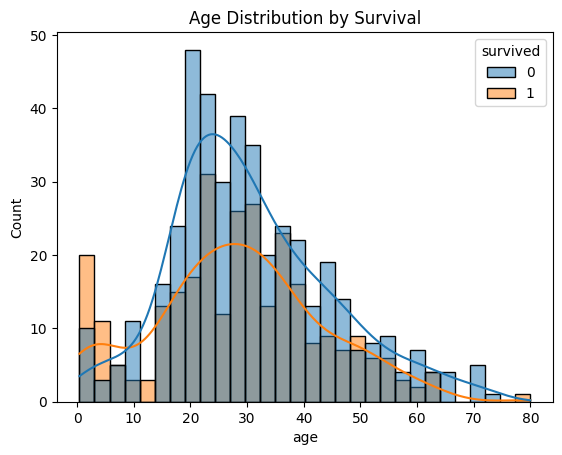

In [11]:
sns.histplot(data=df, x='age', hue='survived', kde=True, bins=30)
plt.title("Age Distribution by Survival")
plt.show()

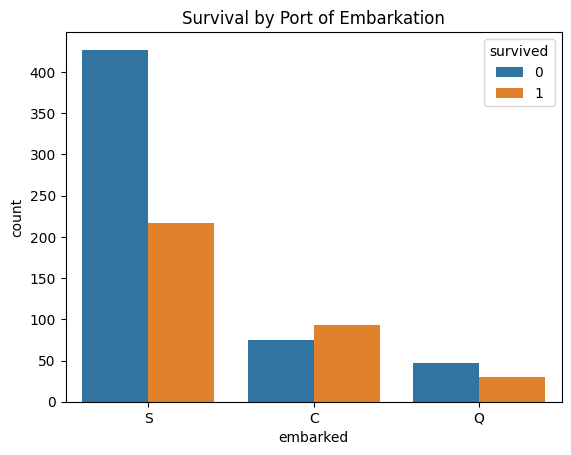

In [12]:
sns.countplot(data=df, x='embarked', hue='survived')
plt.title("Survival by Port of Embarkation")
plt.show()

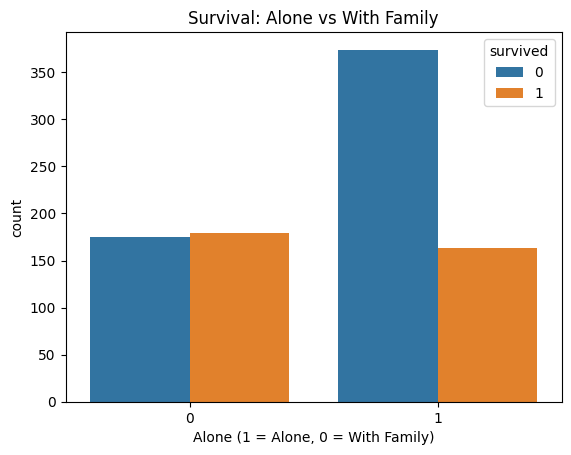

In [13]:
df['family_size'] = df['sibsp'] + df['parch'] + 1
df['alone'] = df['family_size'].apply(lambda x: 1 if x == 1 else 0)

sns.countplot(data=df, x='alone', hue='survived')
plt.title("Survival: Alone vs With Family")
plt.xlabel("Alone (1 = Alone, 0 = With Family)")
plt.show()


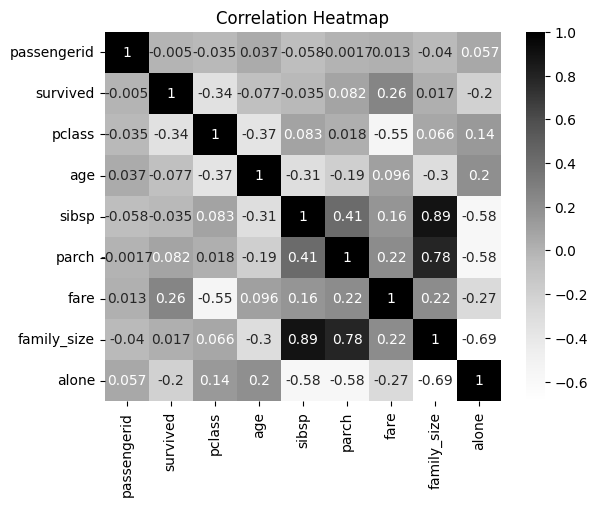

In [14]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Greys')
plt.title("Correlation Heatmap")
plt.show()

## `Split the Dataset`

In [15]:
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked', 'family_size', 'alone'],
      dtype='object')

In [16]:
# to X & y
choosen_features = ["pclass", "sex", "age", "sibsp", "parch", "family_size", "alone", "fare", "embarked"]
X = df[choosen_features]
y = df['survived']

# to train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [17]:
X.head()

,pclass,sex,age,sibsp,parch,family_size,alone,fare,embarked
0,3,male,22.0,1,0,2,0,7.2500,S
1,1,female,38.0,1,0,2,0,71.2833,C
2,3,female,26.0,0,0,1,1,7.9250,S
3,1,female,35.0,1,0,2,0,53.1000,S
4,3,male,35.0,0,0,1,1,8.0500,S


In [18]:
# Check shapes
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print()
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (712, 9)
y_train shape (712,)

X_test shape (179, 9)
y_test shape (179,)


## `Preprocessing`

In [19]:
# Let me divide into 3 subsets
num_cols = ["age", "fare"]
categ_cols = ["sex", "embarked"]
ready_cols = list(set(X_train.columns.tolist()) - set(num_cols) - set(categ_cols))

# check
print("Numerical cols: ", num_cols)
print("Categorical cols: ", categ_cols)
print("Ready cols: ", ready_cols)

Numerical cols:  ['age', 'fare']
Categorical cols:  ['sex', 'embarked']
Ready cols:  ['sibsp', 'pclass', 'alone', 'family_size', 'parch']


In [20]:
# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categ_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('ohe', OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"))
])

# Ready pipeline
read_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent"))
])


# Combine all
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('categ', categ_pipeline, categ_cols),
    ('ready', read_pipeline, ready_cols)
])


# Apply to all data
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [21]:
# Check shapes again
print("X_train_final shape", X_train_final.shape)
print("y_train shape", y_train.shape)
print()
print("X_test_final shape", X_test_final.shape)
print("y_test shape", y_test.shape)

X_train_final shape (712, 10)
y_train shape (712,)

X_test_final shape (179, 10)
y_test shape (179,)


In [22]:
MODELS_FOLDER_PATH = os.path.join(os.getcwd(), "models")
os.makedirs(MODELS_FOLDER_PATH, exist_ok=True)
joblib.dump(preprocessor, os.path.join(MODELS_FOLDER_PATH, "preprocessor.joblib"))

['/content/models/preprocessor.joblib']

## `Basic NN Model`

In [23]:
X_train_final.shape[1]

10

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Fit model (with validation_split instead of validation-data: keeping the test dataset untouched)
history = model.fit(X_train_final, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.6188 - loss: 0.6531 - val_accuracy: 0.6364 - val_loss: 0.6090
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6819 - loss: 0.5932 - val_accuracy: 0.7063 - val_loss: 0.5754
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7159 - loss: 0.5543 - val_accuracy: 0.7552 - val_loss: 0.5263
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7802 - loss: 0.4965 - val_accuracy: 0.7972 - val_loss: 0.4855
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8068 - loss: 0.4793 - val_accuracy: 0.8112 - val_loss: 0.4639
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8130 - loss: 0.4385 - val_accuracy: 0.8042 - val_loss: 0.4641
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8063 - loss: 0.4389 - val_accuracy: 0.7902 - val_loss: 0.4650
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8268 - loss: 0.4199 - val_accuracy: 0.790

In [26]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8048 - loss: 0.5707
Test Loss: 0.6046
Test Accuracy: 0.7989 %


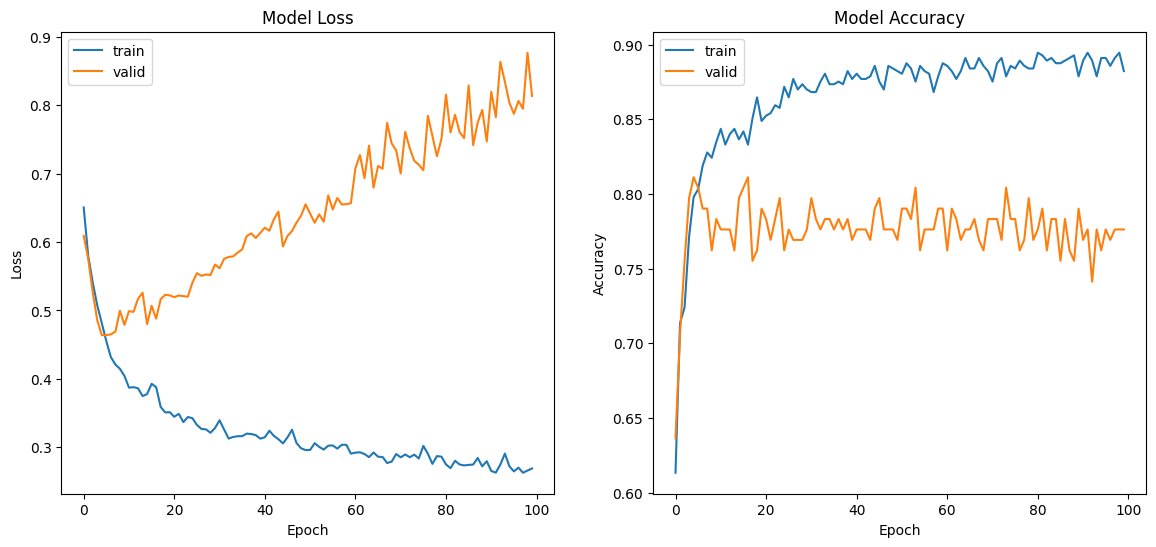

In [27]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Enhancing the Model`

In [32]:
# Try add a reguralizer l2
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer="l2"),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer="l2"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Fit
history = model.fit(X_train_final, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.6289 - loss: 2.2135 - val_accuracy: 0.5944 - val_loss: 1.9665
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6082 - loss: 1.8790 - val_accuracy: 0.6084 - val_loss: 1.6804
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6548 - loss: 1.6089 - val_accuracy: 0.6643 - val_loss: 1.4575
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7049 - loss: 1.3912 - val_accuracy: 0.7483 - val_loss: 1.2733
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7188 - loss: 1.2201 - val_accuracy: 0.7622 - val_loss: 1.1291
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7651 - loss: 1.0670 - val_accuracy: 0.7552 - val_loss: 1.0143
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7663 - loss: 0.9854 - val_accuracy: 0.8042 - val_loss: 0.9210
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7828 - loss: 0.8846 - val_accuracy: 0.7902 -

In [30]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7791 - loss: 0.5310
Test Loss: 0.5174
Test Accuracy: 0.7989 %


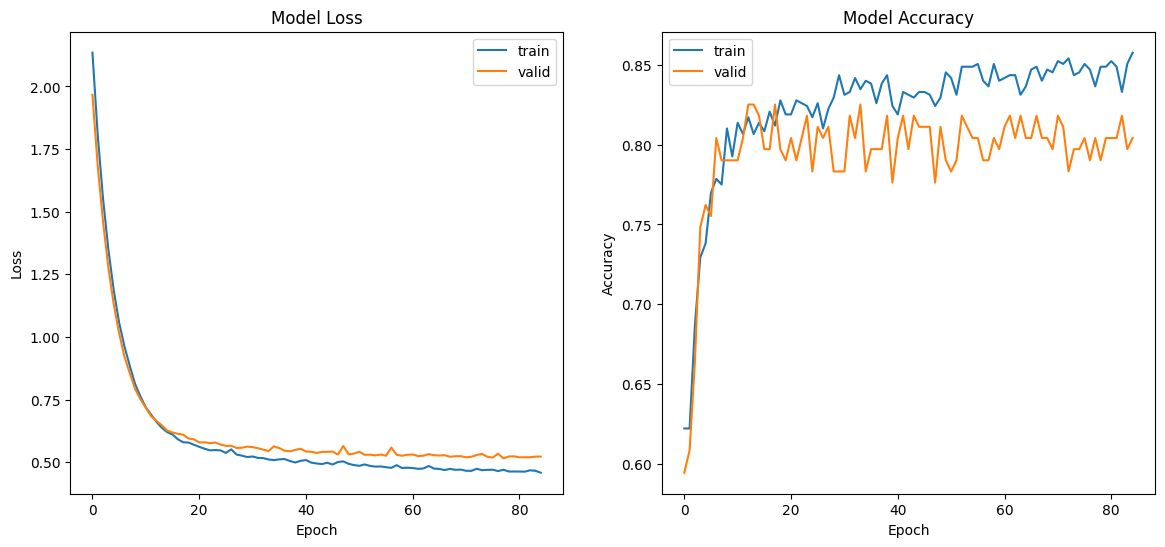

In [31]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Using Keras-Tuner`

In [34]:
# A function to be called for HyperOpt
def build_model(hp):
    model = tf.keras.models.Sequential([

        # Input Layer (preferable)
        tf.keras.layers.Input(shape=(X_train_final.shape[1],)),

        # First Layer
        tf.keras.layers.Dense(units=hp.Int("units_1", min_value=32, max_value=256, step=32),
        activation="relu"),

        # Dropout
        tf.keras.layers.Dropout(hp.Float("dropout_1", min_value=0.0, max_value=0.5, step=0.1)),

        # Second Layer
        tf.keras.layers.Dense(units=hp.Int("units_2", min_value=32, max_value=256, step=32),
        activation="relu"),

        # Dropout
        tf.keras.layers.Dropout(hp.Float("dropout_2", min_value=0.0, max_value=0.5, step=0.1)),

        # Output Layer
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

In [35]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [37]:
# Setting up the Random Search
tuner = RandomSearch(hypermodel=build_model,
                     objective="val_accuracy",
                     max_trials=10,
                     executions_per_trial=2,
                     directory="hyperparam_tuning",
                     project_name="titanic_tuning",
                     seed=174)

In [38]:
# Running tuner
tuner.search(X_train_final, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             )

Trial 10 Complete [00h 00m 16s]
val_accuracy: 0.8286713063716888

Best val_accuracy So Far: 0.8321678340435028
Total elapsed time: 00h 02m 50s


In [39]:
# Getting the best model configuration
best_model = tuner.get_best_models(num_models=1)[0]
best_model

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Sequential name=sequential, built=True>

In [40]:
# Evaluate on test
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7864 - loss: 0.4757
Test Loss: 0.4617
Test Accuracy: 0.7989 %


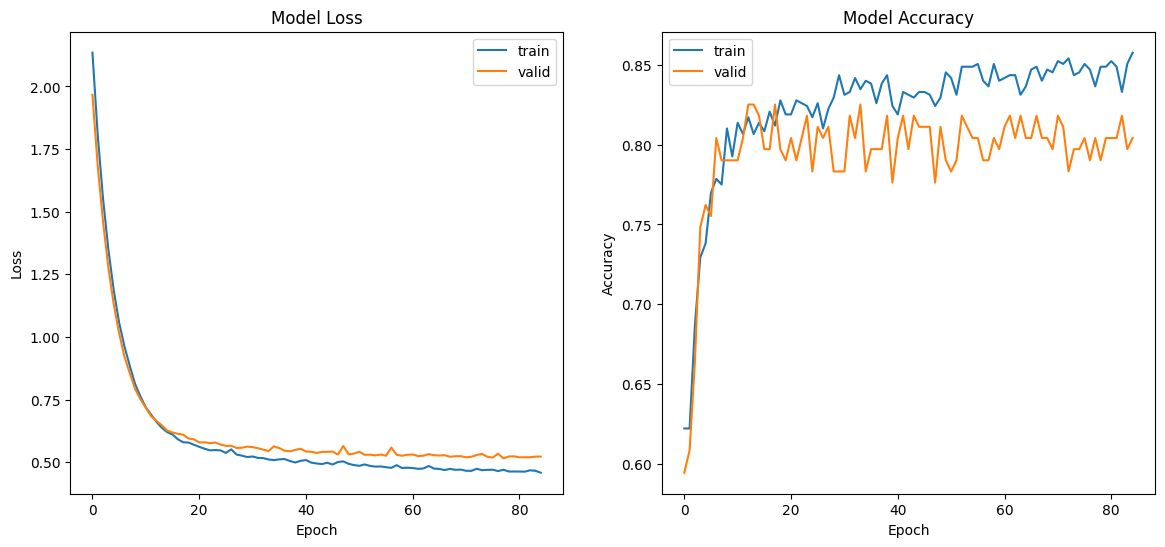

In [41]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Save & Load the Best Model`

In [42]:
# Saving the best model from hyperparameter tuning to a file
best_model.save(os.path.join(MODELS_FOLDER_PATH, "best_titanic_model.keras"))

In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(os.path.join(MODELS_FOLDER_PATH, "best_titanic_model.keras"))

# Evaluate on test
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}") 
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7864 - loss: 0.4757 
Test Loss: 0.4617
Test Accuracy: 0.7989 %


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## `Inference`

In [44]:
df.sample(10)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_size,alone
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9000,NaN,S,8,0
48,49,0,3,"Samaan, Mr. Youssef",male,NaN,2,0,2662,21.6792,NaN,C,3,0
568,569,0,3,"Doharr, Mr. Tannous",male,NaN,0,0,2686,7.2292,NaN,C,1,1
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C,2,0
60,61,0,3,"Sirayanian, Mr. Orsen",male,22.0,0,0,2669,7.2292,NaN,C,1,1
694,695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S,1,1
200,201,0,3,"Vande Walle, Mr. Nestor Cyriel",male,28.0,0,0,345770,9.5000,NaN,S,1,1
784,785,0,3,"Ali, Mr. William",male,25.0,0,0,SOTON/O.Q. 3101312,7.0500,NaN,S,1,1
778,779,0,3,"Kilgannon, Mr. Thomas J",male,NaN,0,0,36865,7.7375,NaN,Q,1,1
134,135,0,2,"Sobey, Mr. Samuel James Hayden",male,25.0,0,0,C.A. 29178,13.0000,NaN,S,1,1


In [45]:
# Let's try simulate inference

# Processing & Predictions
samples = df.sample(10, random_state=14)
samples_processed = preprocessor.transform(samples)
predictions = (model.predict(samples_processed) > 0.5).astype("int32")
predictions.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [46]:
results = pd.DataFrame({
    'Passenger_ID': samples["passengerid"],
    'Predicted': ['Survived' if pred == 1 else 'Not Survived' for pred in predictions.flatten()],
})

results

,Passenger_ID,Predicted
75,76,Not Survived
602,603,Not Survived
119,120,Not Survived
647,648,Not Survived
115,116,Not Survived
472,473,Not Survived
547,548,Not Survived
735,736,Not Survived
467,468,Not Survived
759,760,Survived
